In [1]:
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from functions import *

In [2]:
def plot_vector(F_cpu, component_x_cpu, component_y_cpu, skip = 10, vector_length = 60):
    rho_total = np.sum(F_cpu, axis = 0)
    ux = np.sum(F_cpu * component_x_cpu[:, None, None], axis=0) / rho_total
    uy = np.sum(F_cpu * component_y_cpu[:, None, None], axis=0) / rho_total
    speed  = np.sqrt(ux**2 + uy**2)

    x_coords = np.arange(F_cpu.shape[2])
    y_coords = np.arange(F_cpu.shape[1])
    X, Y     = np.meshgrid(x_coords, y_coords)

    # 3. Optional: thin arrows if the grid is very dense
    X, Y, ux, uy = X[::skip, ::skip], Y[::skip, ::skip], ux[::skip, ::skip]*vector_length, uy[::skip, ::skip]*vector_length
    speed_skip = speed[::skip, ::skip]

    # 4. Plot
    fig, ax = plt.subplots(figsize=(7, 4), dpi=150)
    q = ax.quiver(X, Y, uy, ux, speed_skip,              # arrow base- (X,Y) and components (u,v)
                  angles='xy', scale_units='xy', scale=1,   # keep arrow lengths literal
                  width=0.0025, headwidth=3, headlength=4)  # cosmetics

    ax.set_aspect('equal')                    # square pixels → undistorted arrows
    ax.set_xlabel('x index')
    ax.set_ylabel('y index')
    ax.set_title('Velocity field')
    ax.invert_yaxis()

    # 5. (Optional) Draw underlying magnitude as a background image
    # speed = np.hypot(ux, uy)
    # im = ax.imshow(speed, origin='lower', cmap='viridis', alpha=0.4,
    #                extent=[0, nx-1, 0, ny-1])
    # fig.colorbar(im, ax=ax, label='speed')

    plt.tight_layout()
    plt.show()

In [3]:

# initialize grid
'''length_scale = 15
unit_length = 100
nx = ny = length_scale * unit_length
objects = np.zeros((nx, ny), dtype = bool)
objects[30*length_scale:40*length_scale, 35*length_scale:65*length_scale] = True'''

length_scale = 6
unit_length = 100
nx = length_scale * unit_length * 2
ny = length_scale * unit_length
X, Y = np.meshgrid(range(nx), range(ny))

cylinder = ((X-(nx/4))**2 + (Y-(ny/2))**2) < (ny/6)**2
cylinder = cylinder.T

cylinder[:, 0:1] = True
cylinder[:, -2:-1] = True

objects = cylinder

# velocity components
component_x = np.array([0, 0, 1, 1, 1, 0, -1, -1, -1])
component_y = np.array([0, 1, 1, 0, -1, -1, -1, 0, 1])
w = np.array([4/9, 1/9, 1/36, 1/9, 1/36, 1/9, 1/36, 1/9, 1/36])

# initialize velocity density
F = np.ones((9,nx,ny)) + 0.3*np.random.random((9,nx,ny))
Feq = np.zeros_like(F)
#F[3, :, :] += 0.1
#F[:, objects] = 0
rho_total = np.sum(F, axis = 0)
rho0 = 1
for j in range(9):
    F[j, :, :] *= rho0 / rho_total

# inlet condition
ux_in = 0.16
uy_in = 0.0

# time parameter
tau = 0.75
t_delta = 1
iterations = 10000

D = ny/3
Re = ux_in * D / ((1/3) * (tau - 0.5))
print("Re = ", Re)

Re =  384.0


  0%|          | 0/10000 [00:00<?, ?it/s]

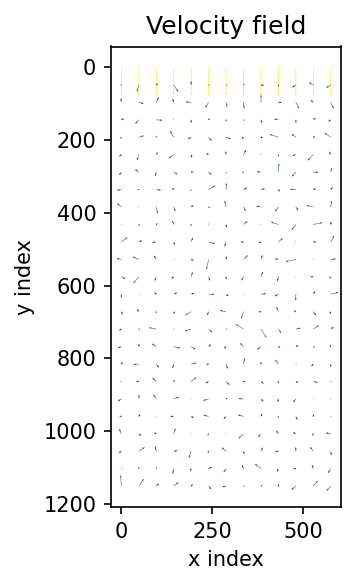

 10%|▉         | 991/10000 [00:06<00:58, 153.01it/s]

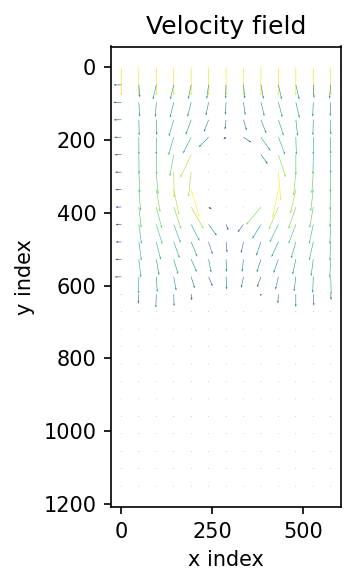

 20%|█▉        | 1996/10000 [00:13<00:51, 153.95it/s]

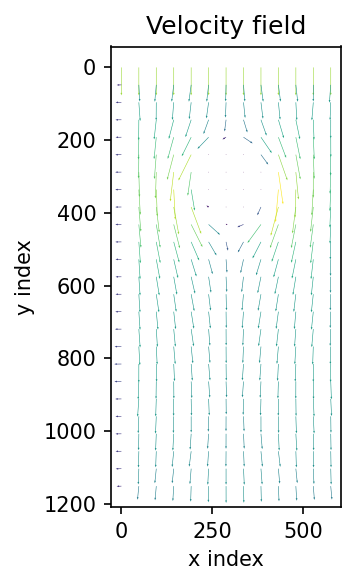

 30%|██▉       | 2999/10000 [00:20<00:45, 154.70it/s]

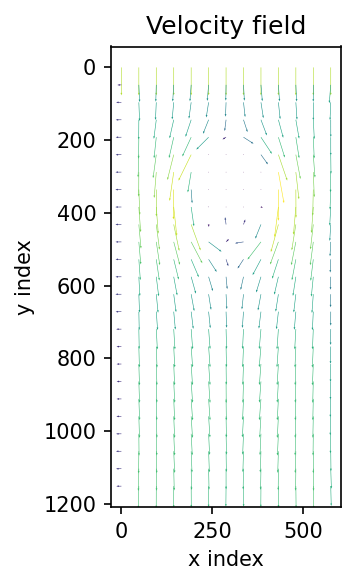

 40%|███▉      | 3990/10000 [00:27<00:39, 153.83it/s]

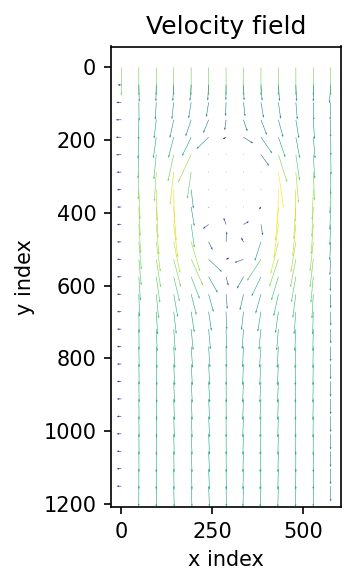

 50%|████▉     | 4997/10000 [00:33<00:32, 153.46it/s]

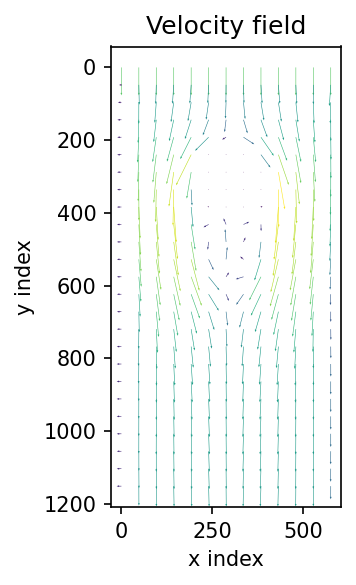

 60%|█████▉    | 5989/10000 [00:40<00:26, 154.22it/s]

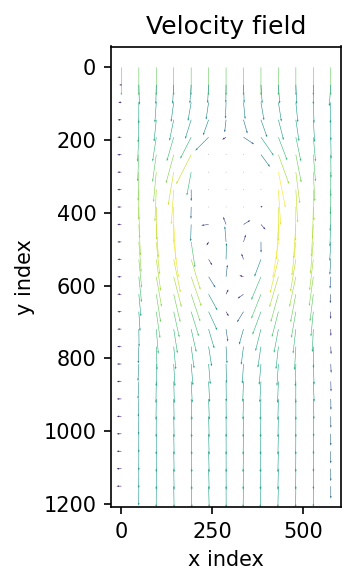

 70%|██████▉   | 6998/10000 [00:47<00:19, 151.56it/s]

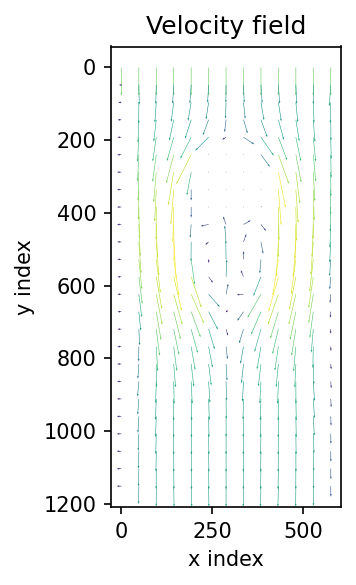

 80%|███████▉  | 7985/10000 [00:53<00:13, 144.65it/s]

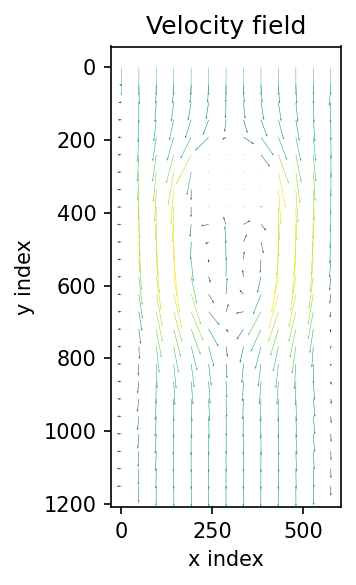

 90%|████████▉ | 8989/10000 [01:00<00:06, 154.24it/s]

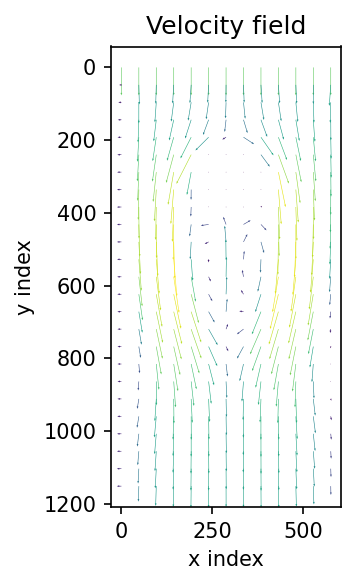

100%|██████████| 10000/10000 [01:07<00:00, 148.57it/s]


In [4]:

component_x = cp.asarray(component_x)
component_y = cp.asarray(component_y)
w = cp.asarray(w)
F = cp.asarray(F)
objects = cp.asarray(objects)

for i in tqdm(range(iterations)):


    F = flow_drift_CUDA(F, component_x, component_y)

    F = inlet_x_CUDA(F, component_x, component_y, w, ux_in, uy_in, rho0, ny)

    F, Feq = collision_equilibrium_CUDA2(F, component_x, component_y, w, t_delta, tau)

    F = boundary_object_CUDA(F, objects)

    '''# objects flow
    inside_boundary = F[:, objects]
    inside_boundary = inside_boundary[[0,5,6,7,8,1,2,3,4], :]
    F[:, objects] = inside_boundary'''

    if i%1000==0:
        F_cpu = cp.asnumpy(Feq)
        component_x_cpu = cp.asnumpy(component_x)
        component_y_cpu = cp.asnumpy(component_y)
        objects_cpu = cp.asnumpy(objects)

        plot_vector(F_cpu, component_x_cpu, component_y_cpu, skip = 8*length_scale, vector_length = 80*length_scale)


In [ ]:
# --- macroscopic fields from the fluid populations F ---
def macroscopic_from_F_CUDA(F, component_x, component_y):
    rho = cp.sum(F, axis=0)
    ux = (F * component_x.reshape((9,1,1))).sum(axis=0) / rho
    uy = (F * component_y.reshape((9,1,1))).sum(axis=0) / rho
    return rho, ux, uy

# --- scalar collision (BGK) for advection–diffusion on D2Q9 ---
# Uses linear equilibrium: g_eq = w * C * (1 + 3 e·u)   (since c_s^2 = 1/3 on D2Q9)
def scalar_collision_equilibrium_CUDA(G, C, ux, uy, component_x, component_y, w, t_delta, tau_g):
    cu = component_x[:, None, None] * ux[None, :, :] + component_y[:, None, None] * uy[None, :, :]
    Geq = w[:, None, None] * C[None, :, :] * (1.0 + 3.0 * cu)
    G = G * (1.0 - t_delta / tau_g) + Geq * (t_delta / tau_g)
    return G

# --- scalar inlet (Dirichlet) + outlet (zero-gradient) ---
# Sets C = C_in at x=0 using local fluid velocity from that vertical line.
def scalar_inlet_dirichlet_CUDA(G, component_x, component_y, w, C_in, ux_line, uy_line):
    # ux_line, uy_line: shape (ny,), fluid velocity at the inlet column (x=0)
    cu_line = component_x[:, None] * ux_line[None, :] + component_y[:, None] * uy_line[None, :]
    Geq_inlet = w[:, None] * C_in * (1.0 + 3.0 * cu_line)
    G[:, 0, :] = Geq_inlet
    # Outlet zero-gradient:
    G[:, -1, :] = G[:, -2, :]
    return G


In [ ]:
# target scalar diffusivity (lattice units)
D_s = 1.0/60.0           # example → tau_g = 0.5 + 3*D_s = 0.55
tau_g = 0.5 + 3.0 * D_s

# initial concentration field (e.g., zero everywhere)
C0 = cp.zeros((nx, ny))

# initialize scalar populations in equilibrium with C0 and (u≈0)
G = (w[:, None, None] * C0[None, :, :]).astype(cp.float64)


In [ ]:
for i in tqdm(range(iterations)):
    # ---- fluid: keep your existing sequence ----
    F = flow_drift_CUDA(F, component_x, component_y)
    F = inlet_x_CUDA(F, component_x, component_y, w, ux_in, uy_in, rho0, ny)
    F = collision_equilibrium_CUDA2(F, component_x, component_y, w, t_delta, tau)
    F = boundary_object_CUDA(F, objects)

    # ---- macroscopic velocity for advection of the scalar ----
    rho, ux, uy = macroscopic_from_F_CUDA(F, component_x, component_y)

    # ---- scalar: stream → inlet (Dirichlet) → collide → bounce-back ----
    G = flow_drift_CUDA(G, component_x, component_y)

    # use the *current fluid inlet* velocities at x=0 for better consistency
    ux_inlet_line = ux[0, :]   # shape (ny,)
    uy_inlet_line = uy[0, :]
    C_in = 1.0                 # set the inlet concentration you want
    G = scalar_inlet_dirichlet_CUDA(G, component_x, component_y, w, C_in, ux_inlet_line, uy_inlet_line)

    # scalar collision
    C = cp.sum(G, axis=0)      # concentration field
    G = scalar_collision_equilibrium_CUDA(G, C, ux, uy, component_x, component_y, w, t_delta, tau_g)

    # walls / cylinder: zero-normal-flux via bounce-back on G as well
    G = boundary_object_CUDA(G, objects)

    # ---- diagnostics/plots every N steps ----
    if i % 100 == 0:
        C_plot = cp.asnumpy(C)   # or compute on the fly: cp.sum(G, axis=0)
        plt.imshow(C_plot.T, origin='lower', cmap='viridis')
        plt.show()
